<h1 align=center><font size = 8>Situación Covid-19 en Galicia</font></h1>

El propósito de este notebook es capturar de la <a href="https://coronavirus.sergas.gal/datos/#/gl-ES/undefined">web del Sergas</a> los datos actualizados de la situación de Galicia frente al Covid-19, y posteriormente realizar algunos análisis básicos, guardando los resultados en directorios.

Para los cálculos basados en el número de habitantes se emplea un fichero csv obteniendo mediante otro notebook, llamado _Población Areas_ y también disponible en el repositorio de GitHub. Se debe de tener en cuenta que en este análisis se trabaja con áreas sanitarias y no con ayuntamientos. Pese a que todos los nombres de las áreas sanitarias coinciden también con nombres de ayuntamientos, en ellas se encuentran englobadas otras comarcas y ayuntamientos limítrofes y próximas.

In [1]:
from classes.covid19galicia import covid19galicia
import pandas as pd

# 1. Importación de datos

Creamos la clase que maneja los datos de la web del Sergas e importamos solamente aquellos que son necesarios para las futuras gráficas.

In [2]:
galicia = covid19galicia()
casos_activos = galicia.getCifrasTotais()
infectados_fecha = galicia.getInfeccionesPorFecha()
camas = galicia.getOcupacionCamas()
fallecidos = galicia.getActivosCuradosFallecidos()
inc14 = galicia.getIncidenciaConcello()

Ultima actualización: 2021-05-05


Podemos visualizar los datos del último día:

In [3]:
total = galicia.getCifrasTotais()
print('En las últimas 24h hubo {} casos en Galicia'.format(total['Casos_Confirmados_PCR_Ultimas24h'].sum()))
total

En las últimas 24h hubo 197 casos en Galicia


,Fecha,Area_Sanitaria,Casos_Totais,Casos_Confirmados_PCR_Ultimas24h,Pacientes_Sin_Alta,Pacientes_Con_Alta,Camas_Ocupadas_HOS,Camas_Ocupadas_UCI,Probas_Realizadas_PCR,Probas_Realizadas_Non_PCR,Exitus
0,2021-05-05,A Coruña,29756,50,702,28481,43,13,458302,246738,586
1,2021-05-05,Ferrol,8453,3,93,8137,8,2,137302,43868,217
2,2021-05-05,Lugo,12519,8,226,12075,5,2,228858,107078,213
3,2021-05-05,Ourense,15419,13,271,14733,15,7,242827,126648,416
4,2021-05-05,Pontevedra,13773,38,488,13113,21,8,217518,110161,173
5,2021-05-05,Santiago,19314,24,395,18571,22,4,339816,172709,360
6,2021-05-05,Vigo,23922,61,897,22605,35,12,467345,113378,427


# 2. Análisis

## 2.1. Casos activos - Total por área sanitaria

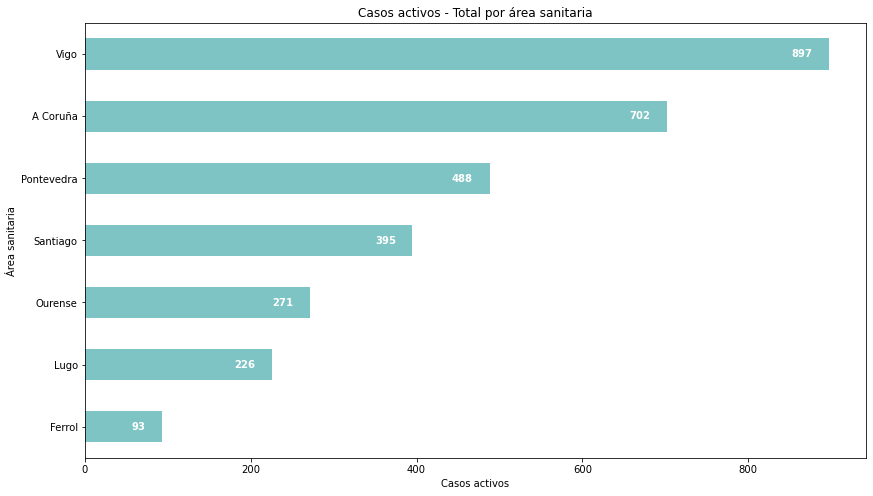

In [4]:
galicia.plotCasosActivos(casos_activos, cienmil=False)

## 2.2. Casos activos - Porcentaje por área sanitaria

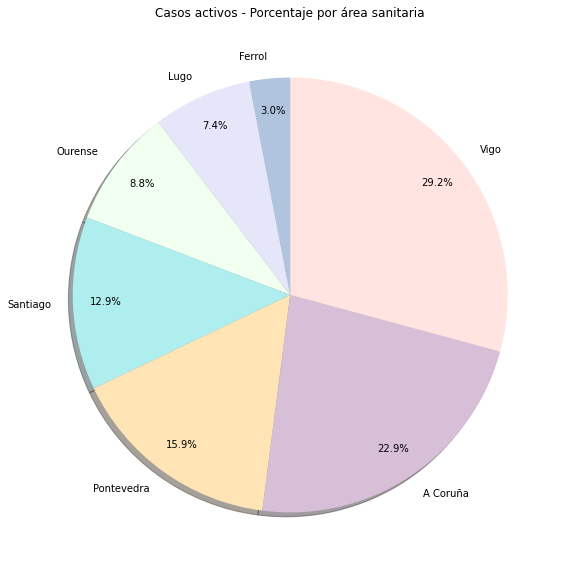

In [5]:
galicia.plotPorcentajeAreas(casos_activos)

## 2.3. Positivos

### 2.3.1. Evolución positivos acumulados últimos 7 días

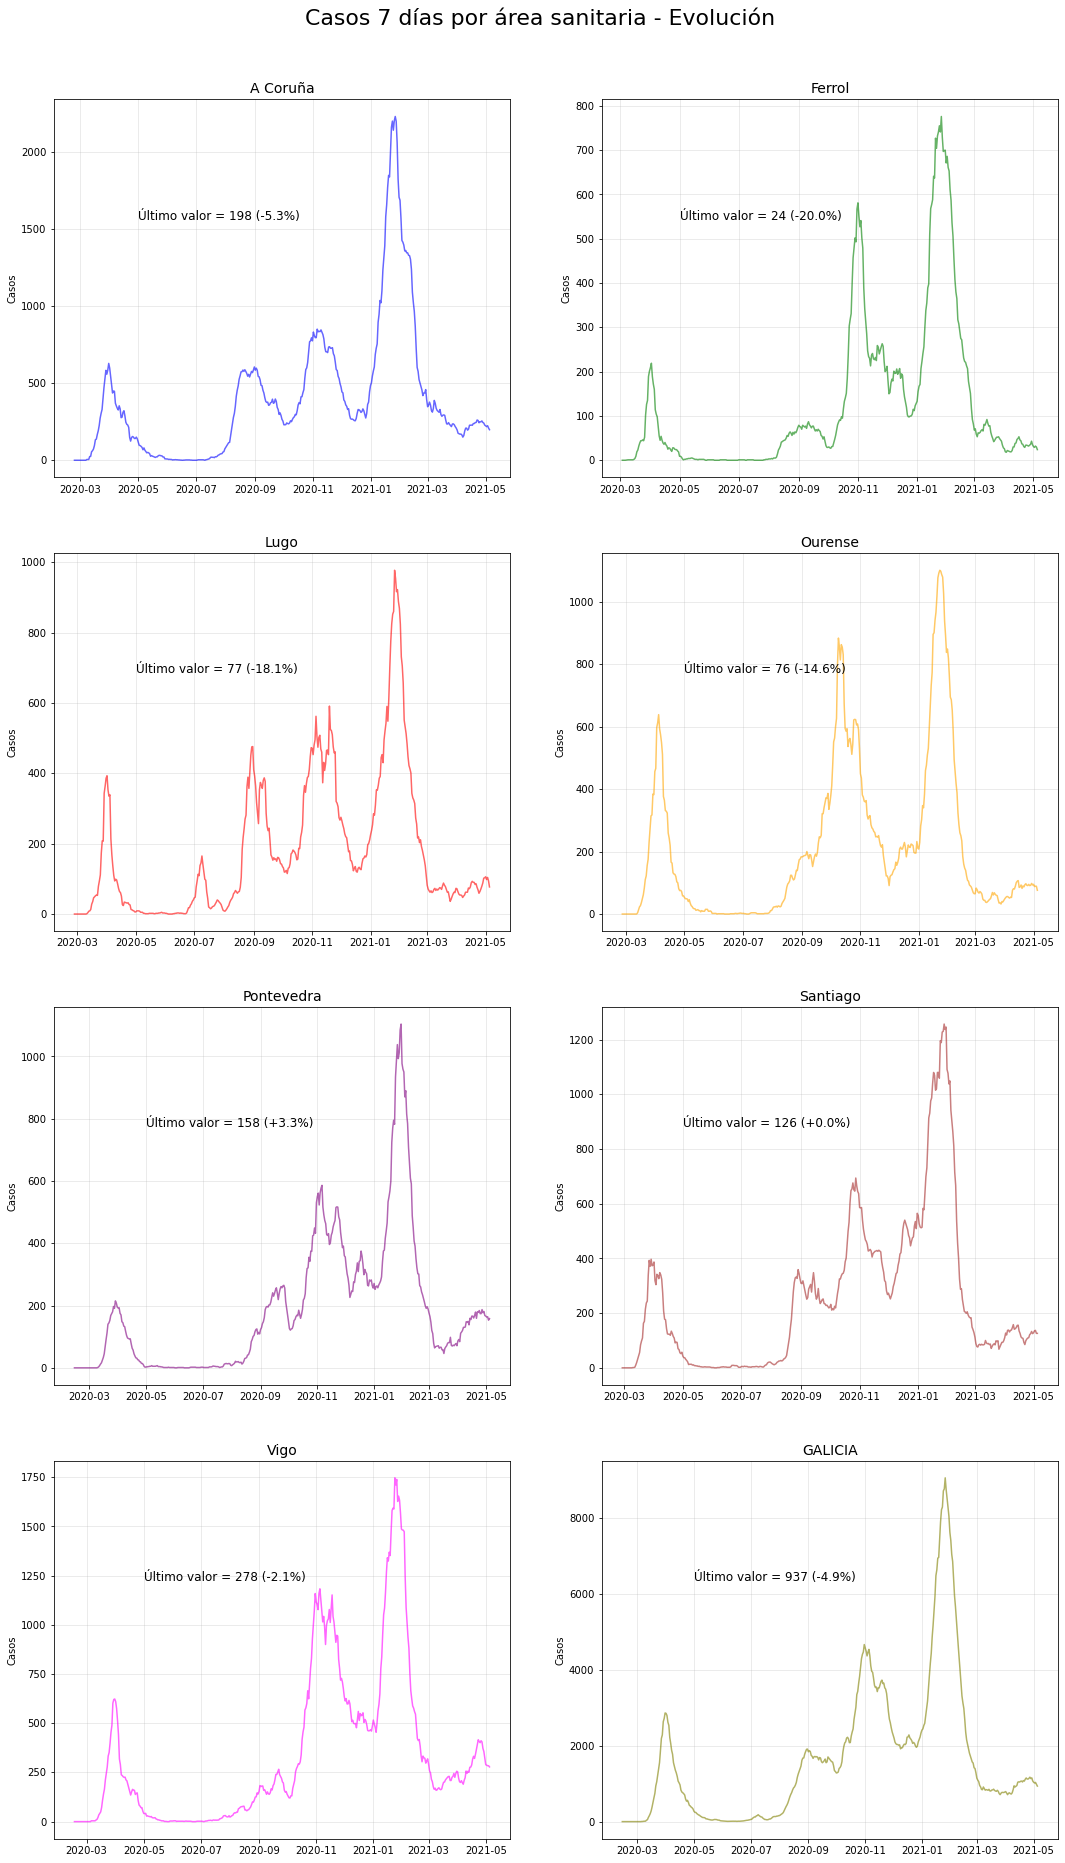

In [6]:
galicia.plotAcumulados(infectados_fecha, kind='Casos', days=7)

### 2.3.2. Comparativo positivos acumulados últimos 7 días

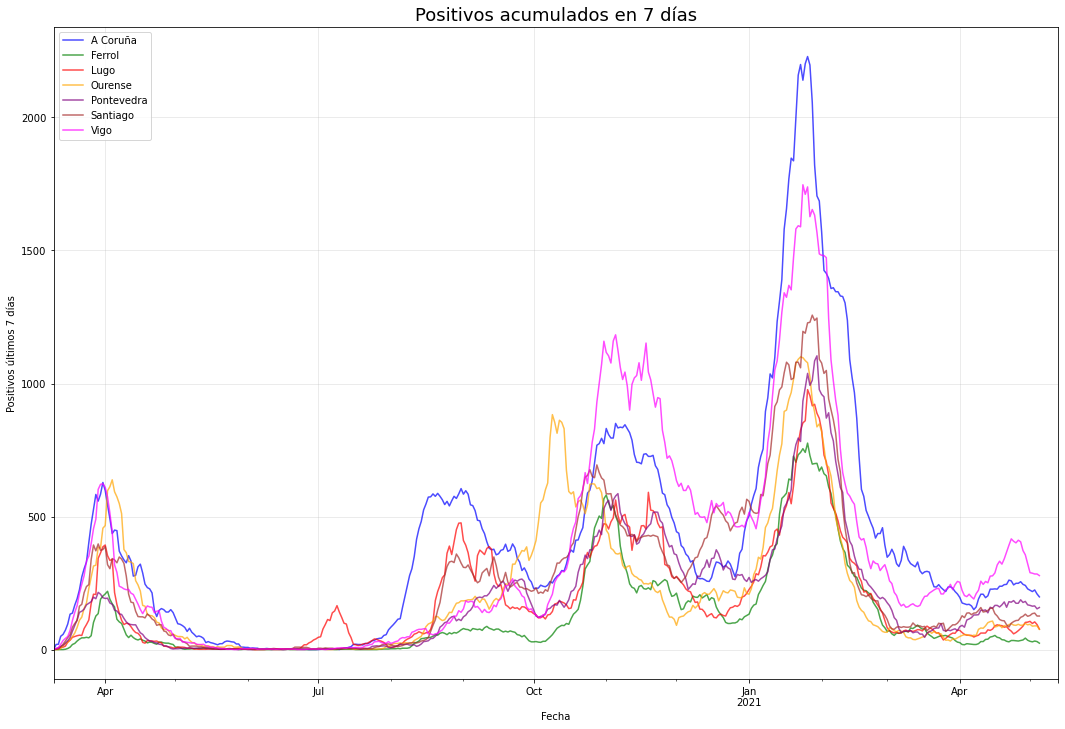

In [7]:
galicia.plotCombinado(infectados_fecha)

### 2.3.3. Principales ciudades - Incidencia 14 días / 100.000 habitantes

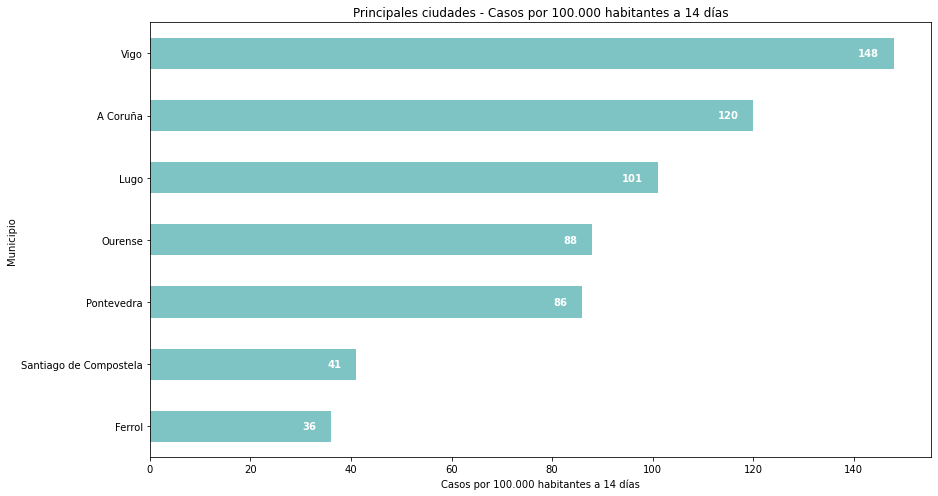

In [8]:
galicia.plotIncidenciaAcumulada(inc14, 'ciudades')

### 2.3.4. Top 10 municipios con mayor incidencia 14 días / 100.000 habitantes

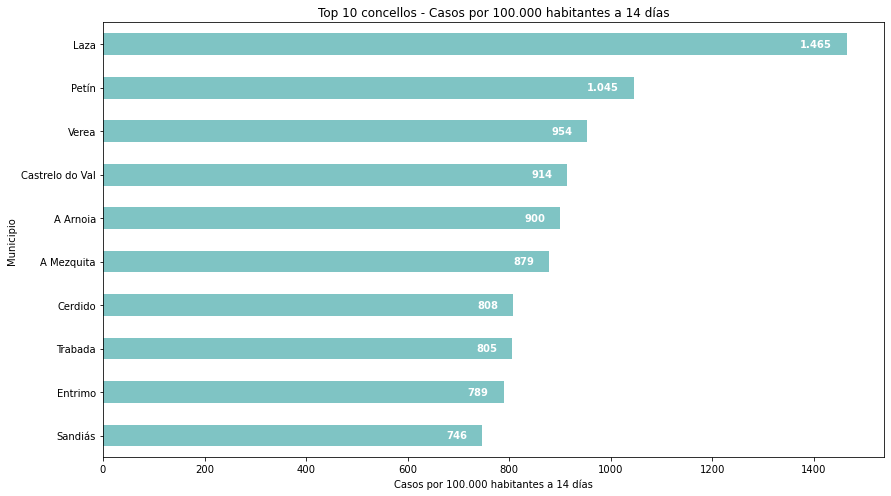

In [9]:
galicia.plotIncidenciaAcumulada(inc14, 'top10')

## 2.4. Evolución PCR acumuladas 7 días

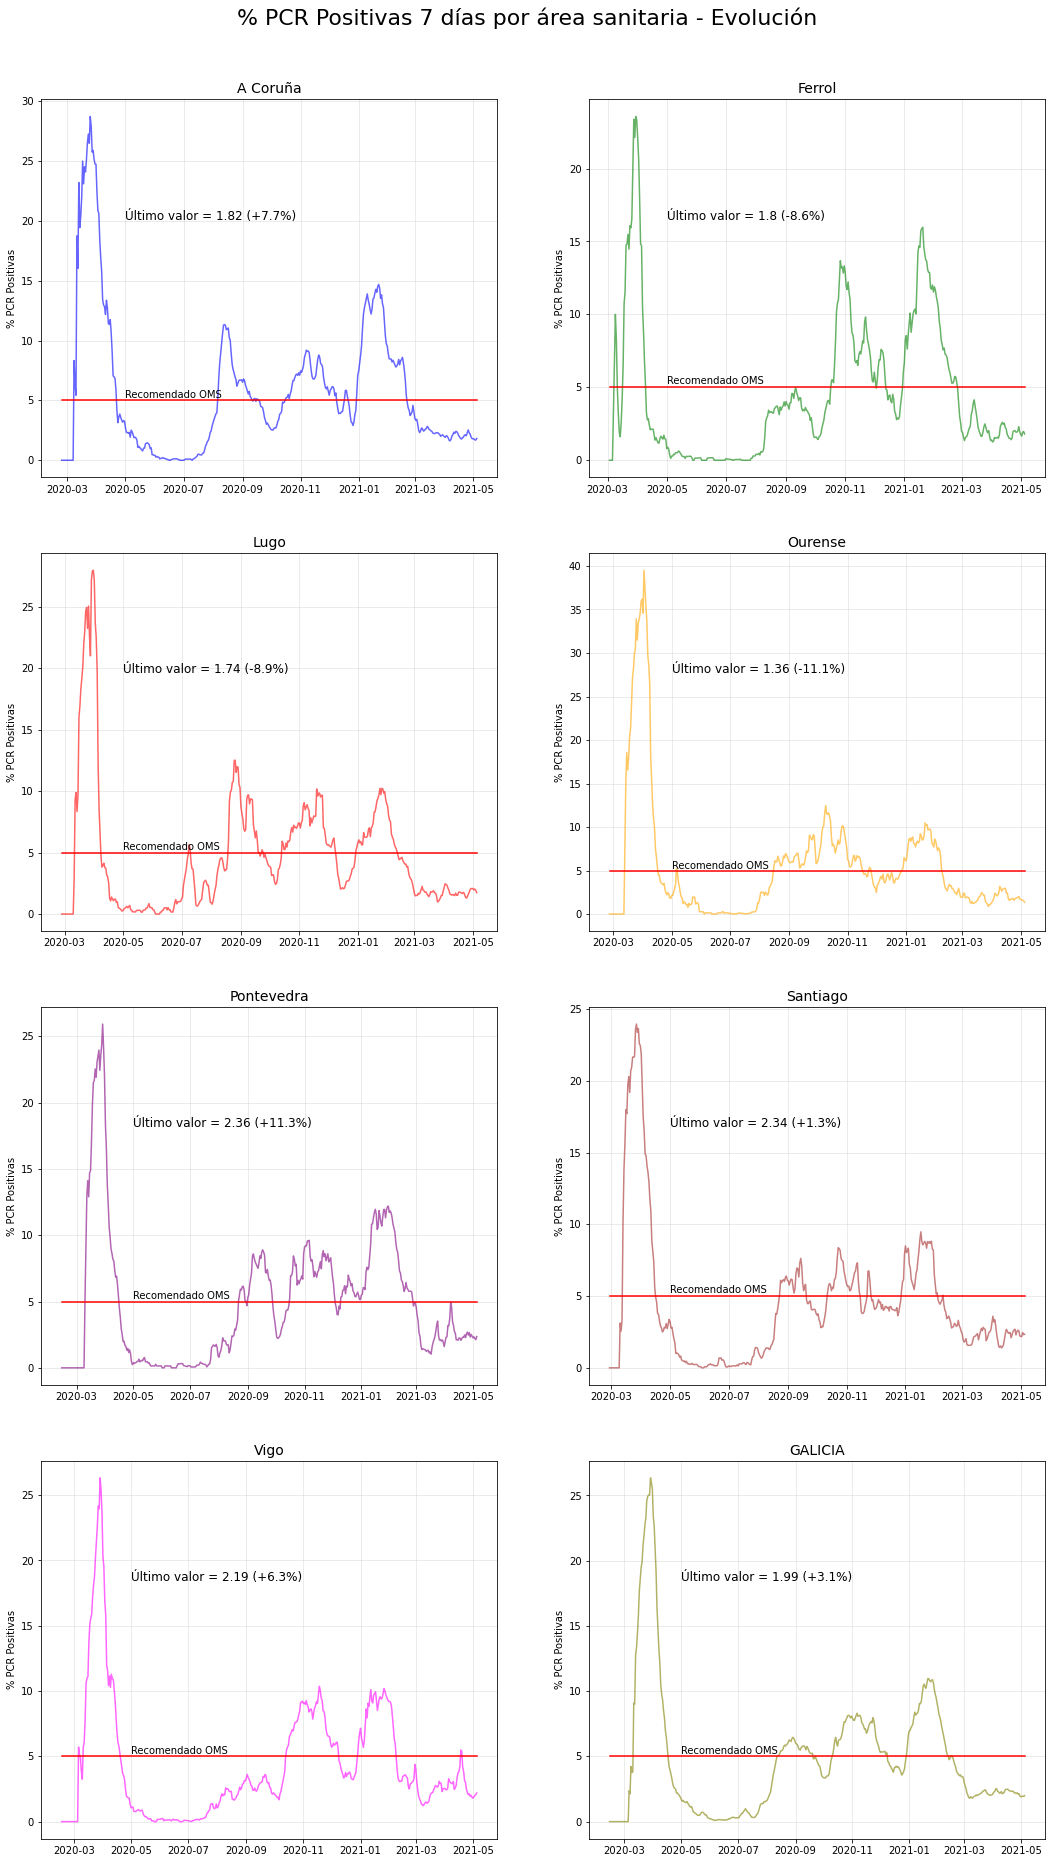

In [10]:
galicia.plotAcumulados(infectados_fecha, kind='PCR', days=7)

## 2.5. Tendencias

### 2.5.1. Clara tendencia en aumento

In [11]:
inc14 = inc14[inc14['Tendencia'].notna()]
inc14 = inc14[inc14['Casos7'] != inc14['Casos']]
inc14.sort_values('Tendencia', ascending=False)
incrementos = list(inc14['Municipio'][inc14['Tendencia'] > 10])
incrementos.sort()
print(*incrementos, sep=', ')

Ames, Arteixo, Betanzos, Bueu, Caldas de Reis, Cambados, Cerdedo-Cotobade, Chantada, Coristanco, Culleredo, Melide, Mesía, Mos, Nigrán, Noia, Padrón, Poio, Redondela, Ribeira, Sada, Silleda, Soutomaior, Teo, Tomiño, Vilanova de Arousa, Xinzo de Limia


### 2.5.2. Clara tendencia en descenso

In [12]:
descensos = list(inc14['Municipio'][inc14['Tendencia'] < -10])
descensos.sort()
print(*descensos, sep=', ')

A Arnoia, A Gudiña, A Illa de Arousa, A Merca, A Rúa, Alfoz, Allariz, Amoeiro, Arzúa, Avión, Bande, Burela, Cambre, Carballo, Cartelle, Castrelo do Val, Celanova, Cerdido, Cervo, Coirós, Cospeito, Dodro, Ferrol, Foz, Gondomar, Lourenzá, Lugo, Marín, Meaño, Moaña, Mondoñedo, Muros, Neda, Nogueira de Ramuín, O Pereiro de Aguiar, O Páramo, O Rosal, Oleiros, Ordes, Paradela, Ponteareas, Pontevedra, Porto do Son, Riós, Rubiá, San Sadurniño, Santiago de Compostela, Sanxenxo, Trabada, Tui, Valdoviño, Verea, Verín, Vigo, Vilamartín de Valdeorras, Vimianzo


## 2.6. Ocupación actual de camas

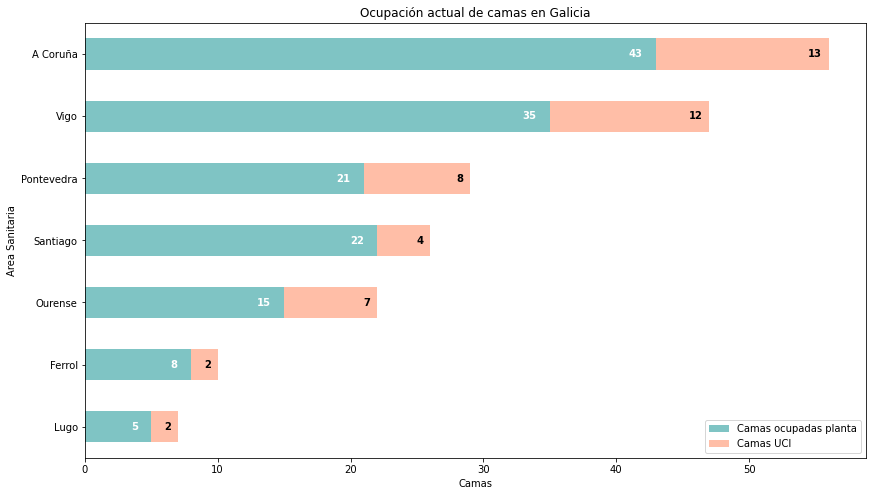

In [13]:
galicia.plotOcupacionCamas(camas)

## 2.7. Fallecidos

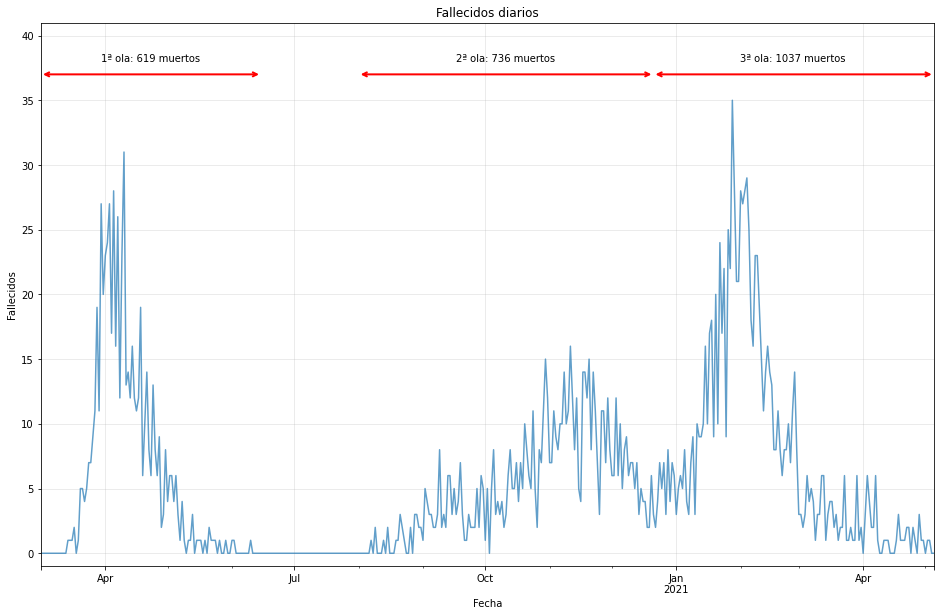

In [14]:
galicia.plotFallecidos(fallecidos)